In [ ]:
!pip install -q flwr[simulation] torch torchvision matplotlib
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.4/200.4 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 71.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 MB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.4/201.4 kB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 82.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.1/98.1 kB 11.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 50.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.9/468.9 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 764.8/764.8 kB 8.

In [ ]:
from collections import OrderedDict
from typing import List, Tuple
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, TensorDataset
from torchvision.datasets import CIFAR10
from torch import Tensor

from dataclasses import dataclass

import random
import pandas as pd

import flwr as fl
from flwr.common import Metrics

random.seed(42)
np.random.seed(42)

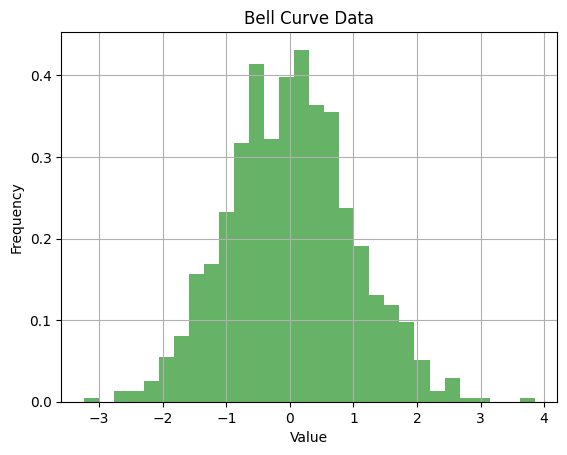

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for the bell curve
mean = 0   # Mean value of the distribution
std_dev = 1  # Standard deviation of the distribution
data_size = 1000  # Number of data points to generate

# Generate normally distributed data using numpy.random.normal()
bell_curve_data = np.random.normal(loc=mean, scale=std_dev, size=data_size)

# Plot the histogram of the bell curve data
plt.hist(bell_curve_data, bins=30, density=True, alpha=0.6, color='g')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Bell Curve Data')
plt.grid(True)
plt.show()


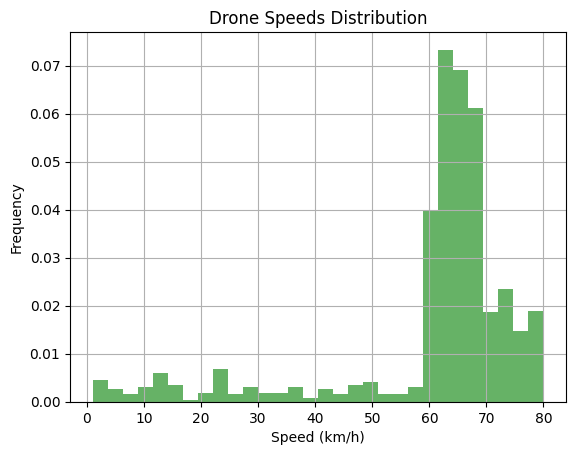

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for the custom distribution
data_size = 1000  # Number of data points to generate

# Generate drone speeds with a custom distribution
# Create a custom distribution with more samples around 60 to 70 km/h and fewer from 1 to 59 km/h
custom_distribution = np.concatenate([np.linspace(1, 59, 50), np.linspace(60, 70, 200), np.linspace(71, 80, 50)])

# Sample from the custom distribution using numpy.random.choice()
drone_speeds = np.random.choice(custom_distribution, size=data_size)

# Plot the histogram of drone speeds
plt.hist(drone_speeds, bins=30, density=True, alpha=0.6, color='g')
plt.xlabel('Speed (km/h)')
plt.ylabel('Frequency')
plt.title('Drone Speeds Distribution')
plt.grid(True)
plt.show()


In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Available device : [{DEVICE}]')

# Creating a Dataset
random.seed(42)
# Define the range of values for each factor
drone_speed_range = (10, 20) # meters per second
parcel_weight_range = (0.1, 3) # kilograms
battery_life_range = (10, 40) # minutes
start_battery_range = (50, 100) # percentage
end_battery_range = (0, 50) # percentage
distance_range = (10, 500) # meters

num_samples = 2000

data = list()

# Generate random values for each factor and calculate the expected and actual delivery time
for i in range(num_samples):
  drone_speed = random.uniform(*drone_speed_range)
  parcel_weight = random.uniform(*parcel_weight_range)
  battery_life = random.uniform(*battery_life_range)
  start_battery = random.uniform(*start_battery_range)
  end_battery = random.uniform(*end_battery_range)
  distance = random.uniform(*distance_range)
  # node_id = random.randint(1,5)

  time_without_weight = distance / drone_speed

  battery_usage_without_weight = (start_battery - end_battery) / 100 * battery_life

  time_with_weight = time_without_weight *  ( parcel_weight / 10 )

  battery_usage_with_weight = battery_usage_without_weight + (parcel_weight / 10) * (start_battery - end_battery) / 100 * battery_life

  expected_time = time_with_weight + battery_usage_with_weight / battery_life * 60

  actual_time = expected_time + random.uniform(-0.1 * expected_time, 0.1 * expected_time)

  data.append([drone_speed, parcel_weight, battery_life, start_battery, end_battery, distance, expected_time, actual_time])

df = pd.DataFrame(data, columns=['drone_speed', 'parcel_weight', 'battery_life', 'start_battery', 'end_battery', 'distance', 'expected_time', 'actual_time'])
# # df.to_csv('drone_delivery_dataset.csv', index=False)

print(df.describe())
# df.hist()


df = np.asarray(df)


Available device : [cpu]
       drone_speed  parcel_weight  battery_life  start_battery  end_battery  \
count  2000.000000    2000.000000   2000.000000    2000.000000  2000.000000   
mean     15.056935       1.556144     24.914594      74.773062    25.172570   
std       2.850313       0.838403      8.606129      14.494609    14.393726   
min      10.002707       0.101663     10.001071      50.004617     0.017681   
25%      12.608406       0.845665     17.376793      62.440438    13.150004   
50%      14.998353       1.554478     24.836461      74.781763    24.951903   
75%      17.491059       2.296365     32.497477      86.767721    37.394244   
max      19.987233       2.998373     39.997235      99.994978    49.978621   

          distance  expected_time  actual_time  
count  2000.000000    2000.000000  2000.000000  
mean    249.886433      37.118821    37.207691  
std     142.497593      15.131700    15.404289  
min      10.004645       0.885564     0.880367  
25%     126.564153

In [ ]:
BATCH_SIZE = 32
NUM_CLIENTS= 5


def load_datasets(df):
    # transform = transforms.Compose(
    #     [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    # )

    x_train, y_train = df[0:1500,:-1], df[0:1500,-1]
    x_test, y_test = df[1501:2000,:-1], df[1501:2000,-1]

    x_train = torch.tensor(x_train, dtype=torch.long)
    y_train = torch.tensor(y_train, dtype=torch.long)
    x_train = x_train.to(torch.float32)
    y_train = y_train.to(torch.float32)
    y_train = y_train.view(1500,1)
    print(x_train.shape , y_train.shape)

    x_test = torch.tensor(x_test, dtype=torch.long)
    y_test = torch.tensor(y_test, dtype=torch.long)
    x_test = x_test.to(torch.float32)
    y_test = y_test.to(torch.float32)
    y_test = y_test.view(499,1)
    print(x_test.shape , y_test.shape)

    trainset = TensorDataset( Tensor(x_train), Tensor(y_train) )
    testset = TensorDataset( Tensor(x_test), Tensor(y_test) )

    # Split training set into 10 partitions to simulate the individual dataset
    partition_size = len(trainset) // NUM_CLIENTS
    lengths = [partition_size] * NUM_CLIENTS
    datasets = random_split(trainset, lengths, torch.Generator().manual_seed(42))

    # Split each partition into train/val and create DataLoader
    trainloaders = []
    valloaders = []
    for ds in datasets:
        len_val = len(ds) // 10  # 10 % validation set
        len_train = len(ds) - len_val
        lengths = [len_train, len_val]
        ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(42))
        trainloaders.append(DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True))
        valloaders.append(DataLoader(ds_val, batch_size=BATCH_SIZE))
    testloader = DataLoader(testset, batch_size=BATCH_SIZE)
    return trainloaders, valloaders, testloader


trainloaders, valloaders, testloader = load_datasets(df)


torch.Size([1500, 7]) torch.Size([1500, 1])
torch.Size([499, 7]) torch.Size([499, 1])


Final test set performance:
	loss 0.5978436880933498
	accuracy 0.0


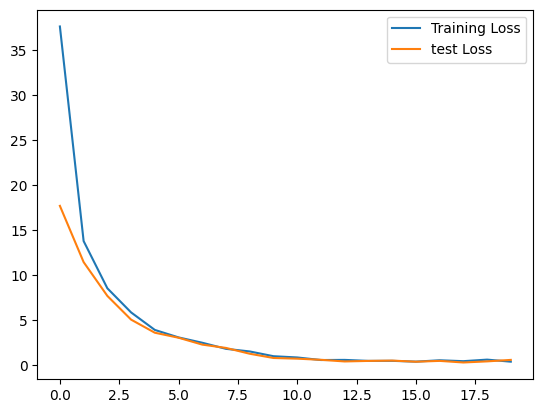

In [ ]:
from torchmetrics.functional import r2_score
random.seed(42)
np.random.seed(42)
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(7, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x


def train(net, trainloader, epochs: int, verbose=False):
    """Train the network on the training set."""
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    each_node_train_loss = []
    each_node_valid_loss = []
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        lo = []
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        each_node_train_loss.append(epoch_loss.detach().numpy())
        #lo.append(epoch_loss)
        epoch_acc = correct / total
        # plt.plot(epoch_loss)
        if verbose:
            print(f"Epoch {epoch+1}: train loss {epoch_loss}")


        # # Validation loop
        # net.eval()  # Set the model to evaluation mode
        # total_val_loss = 0.0

        # with torch.no_grad():
        #     for inputs, labels in valloaders[0]:
        #         inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        #         # Forward pass
        #         outputs = net(inputs)
        #         loss = criterion(outputs, labels)

        #         total_val_loss += loss.item()

        # avg_val_loss = total_val_loss / len(testloader.dataset)
        # each_node_valid_loss.append(avg_val_loss)




    return each_node_train_loss #, each_node_valid_loss


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.MSELoss()
    correct, total, loss, r2loss = 0, 0, 0.0 , 0
    loss_list = []

    net.eval()
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = net(inputs )
            loss += criterion(outputs, labels).item()
            r2loss += r2_score(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total

    return loss, accuracy




trainloader = trainloaders[0]
valloader = valloaders[0]

net = Net().to(DEVICE)
test_loss = []
node_loss = []
node_valid_loss = []
for epoch in range(20):
    node_tain = train(net, trainloader, 1, verbose=False)
    node_loss.append(node_tain)
    # node_valid_loss.append(node_valid)
    loss, accuracy = test(net, testloader)
    test_loss.append(loss)

    # print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")

loss, accuracy = test(net, testloader)
print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")

train_loss = [tensor.item() for sublist in node_loss for tensor in sublist]

plt.plot(train_loss, label='Training Loss')
# plt.plot(node_valid_loss, label='Valid Loss')

plt.plot(test_loss, label='test Loss')
plt.legend()
plt.show()




In [ ]:
from torchsummary import summary
summary(net, (32,7))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 32, 64]             512
              ReLU-2               [-1, 32, 64]               0
            Linear-3               [-1, 32, 32]           2,080
              ReLU-4               [-1, 32, 32]               0
            Linear-5                [-1, 32, 1]              33
Total params: 2,625
Trainable params: 2,625
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.01
Estimated Total Size (MB): 0.06
----------------------------------------------------------------


In [ ]:
def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]


def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)



In [ ]:
from scipy.integrate import quad

""" Nash Equilibrium Values Calculation """
# write the function values for each of it
n= 5
# node_cost = 0.4
highest_value = 2

def integ(total_resource_cost, score):
    def NE(x):
        # return total_resource_cost * ((1 - np.exp(-score)) / (1 - np.exp(-highest_value)))**(n-3)
        return total_resource_cost * (score / highest_value)**(n-2)


    integral, _ = quad(NE, 0, highest_value)
    print("The Integral Value is = ", integral)

    return integral



""" NE END """


def normalize(data, data_min, data_max):
    d = (data - data_min) / (data_max - data_min)
    return d


""" Functions"""

class Euler():
  def __init__(self, X_init =1, Y_init=1 , step =10 ):
    self.x = np.zeros(step+1)
    self.y = np.zeros(step+1)

    self.x[0] = X_init
    self.y[0] = Y_init
    self.step = step


  def function(self,y,x):
    return y

  def approximate_value(self, x_required):
    h = (x_required - self.x[0]) / self.step

    for k in range(self.step):
      self.x[k+1] = self.x[k] + h
      self.y[k+1] = self.y[k] + h * self.function(self.y[k], self.x[k])
    return self.y[-1]


# Nash Equilibrium
def nash_equilibrium():
  # For each node, calculate q(θ) and p(θ)
  pass



def calculate_p(q):
  resource_value = sum(alpha * q)
  total_resource_cost = sum(resource_cost * q)
  profit = resource_value - total_resource_cost
  euler = Euler()
  p = euler.approximate_value(profit)

  # Have to modify accordingly

  resource_value = sum(alpha * q) + p
  total_resource_cost = sum(resource_cost * q)


  return round(p,2), total_resource_cost


def scoring_function(q,p):
  return np.sum(alpha*q) + p #np.min(alpha * q) +p

In [ ]:
from typing import Dict, Tuple

from flwr.common import Config, NDArrays, Scalar
from flwr.common.logger import log
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from logging import WARNING
from typing import Callable, Dict, List, Optional, Tuple, Union

from flwr.common import (
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    GetPropertiesIns,
    MetricsAggregationFn,
    NDArrays,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
    Config
)


In [ ]:
random.seed(42)

P_MIN = 0.021334328158479184
P_MAX = 0.03875953108451435

DATA_MIN = int(1000)
DATA_MAX = int(5000)

BANDWIDTH_MIN = int(5)
BANDWIDTH_MAX = int(100)

RESOURCE = np.array([[random.randint(BANDWIDTH_MIN,BANDWIDTH_MAX), random.randint(DATA_MIN,DATA_MAX)]], dtype=float) # Bandwidth , Data

alpha = [0.5,0.5] # Alpha value for each feature,
resource_cost = [0.6 , 0.4] # cost for each resource
K= 2


In [ ]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["loss"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

In [ ]:
def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]


def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

total_loss= []

class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader
        self.total_loss=list()

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=1)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        self.total_loss.append(loss)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}
    def get_value(self):
      print("value is ", self.total_loss)


def client_fn(cid: str) -> FlowerClient:
    """Create a Flower client representing a single organization."""

    # Load model
    net = Net().to(DEVICE)


    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]
    cl = FlowerClient(net, trainloader, valloader)
    cl.get_value()

    return cl


# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,  # Sample 100% of available clients for training
    fraction_evaluate=0.5,  # Sample 50% of available clients for evaluation
    min_fit_clients=5,  # Never sample less than 10 clients for training
    min_evaluate_clients=3,  # Never sample less than 5 clients for evaluation
    min_available_clients=5,  # Wait until all 10 clients are available
)

# Specify client resources if you need GPU (defaults to 1 CPU and 0 GPU)
client_resources = None
if DEVICE.type == "cuda":
    client_resources = {"num_gpus": 1}


NUM_CLIENTS = 5
num_rounds = 4
# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=num_rounds),
    strategy=strategy,
    client_resources=client_resources,
)

INFO flwr 2023-09-19 16:55:27,179 | app.py:175 | Starting Flower simulation, config: ServerConfig(num_rounds=4, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=4, round_timeout=None)
2023-09-19 16:55:35,613	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2023-09-19 16:55:39,843 | app.py:210 | Flower VCE: Ray initialized with resources: {'object_store_memory': 3899448115.0, 'memory': 7798896231.0, 'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0, 'CPU': 2.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'object_store_memory': 3899448115.0, 'memory': 7798896231.0, 'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0, 'CPU': 2.0}
INFO flwr 2023-09-19 16:55:39,850 | app.py:218 | No `client_resources` specified. Using minimal resources for clients.
INFO:flwr:No `client_resources` specified. Using minimal resources for clients.
INFO flwr 2023-09-19 16:55:39,857 | app.py:224 | Flower VCE: Resources for each Virtual Clie

(DefaultActor pid=780) value is  []
(DefaultActor pid=780) value is  []
(DefaultActor pid=780) value is  []
(DefaultActor pid=780) value is  []
(DefaultActor pid=780) value is  []


DEBUG flwr 2023-09-19 16:56:03,478 | server.py:236 | fit_round 1 received 5 results and 0 failures
DEBUG:flwr:fit_round 1 received 5 results and 0 failures
WARNING flwr 2023-09-19 16:56:03,500 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-09-19 16:56:03,507 | server.py:173 | evaluate_round 1: strategy sampled 3 clients (out of 5)
DEBUG:flwr:evaluate_round 1: strategy sampled 3 clients (out of 5)
DEBUG flwr 2023-09-19 16:56:03,617 | server.py:187 | evaluate_round 1 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 3 results and 0 failures
WARNING flwr 2023-09-19 16:56:03,620 | fedavg.py:273 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-09-19 16:56:03,626 | server.py:222 | fit_round 2: strategy sampled 5 clients (out of 5)
DEBUG:flwr:fit_round 2: strategy sampled 5 clients (out of 5)
DEBUG flwr 2023-09-19 16:56:03,909 | server.py:236 | fit_round 2 received 5 results and 0 failures
DEBUG:flwr:fit_round 2 received 5 results an

History (loss, distributed):
	round 1: 12.276316324869791
	round 2: 10.434887186686197
	round 3: 7.108849080403645
	round 4: 4.325092569986979

In [ ]:

class FlowerClient(fl.client.NumPyClient):

    def __init__(self, cid, net, trainloader, valloader):
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader
        self.payment = list()
        self.node_train_loss = list()
        self.node_valid_loss = list()
        self.server_round =1
        self.RESOURCE = np.array([[self.cid,normalize(random.randint(BANDWIDTH_MIN,BANDWIDTH_MAX),BANDWIDTH_MIN,BANDWIDTH_MAX), normalize(random.randint(DATA_MIN,DATA_MAX),DATA_MIN,DATA_MAX)]] , dtype=float) # ID,Bandwidth , Data



    # return res. as dictionary here
    def get_properties(self, config: Config) -> Dict[str, Scalar]:
        retDict = {"client_id": self.cid,"bandwidth" : self.RESOURCE[0][1], "data" : self.RESOURCE[0][2]}
        return retDict



    # Return the current local model parameters
    def get_parameters(self, config):
        print(f"[Client {self.cid}] get_parameters")
        return get_parameters(self.net)



    # Receive model parameters from the server, train the model parameters on the local data, and return the (updated) model parameters to the server
    def fit(self, parameters, config):

        # Read values from config
        server_round = 1 #config["server_round"]
        local_epochs = 5 #config["local_epochs"]

        score = config["bid_score"]


        if "train" in config:
          print(str(self.cid) + " -> Please try train")
          self.payment.append(config["payment"])
          print("Payment Received",self.payment)


          # Use values provided by the config
          print(f"[Client {self.cid}, round {server_round}] fit, config: {config}")

          set_parameters(self.net, parameters)
          node_loss = train(self.net, self.trainloader, epochs=local_epochs)

          values_train_loss = [arr.item() for arr in node_loss]

          print("Values of each node loss",values_train_loss)
          self.node_train_loss.append(values_train_loss)
          plt.plot(self.node_train_loss[0], label="Training Loss" )
          plt.title(f'Loss for Node {self.cid}')
          plt.xticks(np.arange(local_epochs))
          plt.savefig(f"Model_loss for Node_{self.cid}.png")
          plt.show()


        else:

          print("skip training")

        results = dict()
        results["node_train_loss"] = self.node_train_loss[0]



        return get_parameters(self.net), len(self.trainloader), {}



    # : Receive model parameters from the server, evaluate the model parameters on the local data, and return the evaluation result to the server
    def evaluate(self, parameters, config):

        print(f"[Client {self.cid}] evaluate, config: {config}")
        set_parameters(self.net, parameters)

        loss, accuracy = test(self.net, self.valloader)

        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


    def get_node_losses(self):

      return self.node_train_loss




def fit_config(server_round: int):
    """Return training configuration dict for each round.
    """

    config = {

        "server_round": server_round,  # The current round of federated learning
        "local_epochs": 1 if server_round < 2 else 2,  #
    }
    return config




def client_fn(cid: str) -> FlowerClient:
    """Create a Flower client representing a single organization."""
    net = Net().to(DEVICE)

    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]

    # Create a  single Flower client representing a single organization
    cl = FlowerClient(cid, net, trainloader, valloader)

    return cl



class MyStrategy(fl.server.strategy.FedAvg):
    #def initialize_parameters(self, client_manager):
        # Your implementation here

    def configure_fit(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager) -> List[Tuple[ClientProxy, FitIns]]:
        all_connected_clients_dict = client_manager.all()
        all_client_properties = list()

        for dict_key in all_connected_clients_dict.keys():
          config = {}
          ins = GetPropertiesIns(config=config)
          res = all_connected_clients_dict[dict_key].get_properties(ins, 100)
          res = (res.properties)
          all_client_properties.append(res)

        # preprocess to calculte bid Score  and p_value

        client_id = [[client_id["client_id"]] for client_id in  all_client_properties]
        bandwidth_data = [[d["bandwidth"],d["data"]] for d in all_client_properties]
        bandwidth_data = np.asarray(bandwidth_data)
        print("bandwidth_data",bandwidth_data)


        """
        # NE to calculate Payment Allocation

        """
        scoring_board = list()
        p_client = list()
        payment = list()
        for q in bandwidth_data:

          p_value, total_resource_cost = calculate_p(q)
          p_client.append(p_value)

          client_bid_socre = scoring_function(q,p_value)

          """ NE """
          node_payment = client_bid_socre  + integ(total_resource_cost,client_bid_socre)

          """ NE """

          scoring_board.append(client_bid_socre)
          payment.append(node_payment*100)
          print(client_bid_socre, node_payment)


        score_dic = [{"client_id":id , "bid_score" : score , "p_value" : p , "payment" : node_payment } for id, score , p ,node_payment  in zip(client_id,scoring_board, p_client,payment)]
        print("Client Scoring Board",score_dic)

        top_k = sorted(score_dic, key=lambda x:x["bid_score"], reverse =True)
        top_k = top_k[:K]
        print("The Client with Higher Score", top_k)


        # Selecting the Top k for Training
        client_to_train = list()
        top_client_ids = [[client_id["client_id"]] for client_id in  top_k]


        # chosing client for training
        for client in top_k:


          client_id = client["client_id"]
          payment = client["payment"]
          score = client["bid_score"]

          proxy = all_connected_clients_dict[str(client_id[0][0])]
          # print("proxy", proxy)

          # Create a dict to send instruction
          dic = {"train" : True,"bid_score" :score ,"payment" : payment}

          fitIn = FitIns(parameters=parameters, config=dic)
          client_to_train.append([proxy, fitIn])

        print("Returing to CLient to Train")
        return client_to_train



    def aggregate_fit(self, server_round, results, failures):
        aggregated_parameters, aggregated_metrics = super().aggregate_fit(server_round, results, failures)

        if aggregated_parameters is not None:
          # Convert `Parameters` to `List[np.ndarray]`
          aggregated_ndarrays: List[np.ndarray] = fl.common.parameters_to_ndarrays(aggregated_parameters)

          # Save aggregated_ndarrays
          print(f"Saving round {server_round} aggregated_ndarrays...")
          np.savez(f"round-{server_round}-weights.npz", *aggregated_ndarrays)

        print("Server round -> " + str(server_round))
        # for result in results:
        #   print("Here is the result", str(result.FitRes))

        return aggregated_parameters, aggregated_metrics


    #def configure_evaluate(self, server_round, parameters, client_manager):
        # Your implementation here

    # def aggregate_evaluate(self, server_round, results, failures):
        # Your implementation here

    #def evaluate(self, parameters):
        # Your implementation here
NUM_CLIENTS = 5
NUM_ROUND = 4



strategy = MyStrategy(
    fraction_fit=1,
    fraction_evaluate=1,
    min_fit_clients=NUM_CLIENTS,
    min_evaluate_clients=NUM_CLIENTS,
    min_available_clients=NUM_CLIENTS,
    initial_parameters=fl.common.ndarrays_to_parameters(get_parameters(Net())),
    # evaluate_fn=evaluate,
    on_fit_config_fn=fit_config,  # Pass the fit_config function
)




client_resources = None
if DEVICE.type == "cuda":
    client_resources = {"num_gpus": 1}


fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=NUM_ROUND),
    strategy=strategy,
    client_resources=client_resources,
)


INFO flwr 2023-09-19 16:56:05,192 | app.py:175 | Starting Flower simulation, config: ServerConfig(num_rounds=4, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=4, round_timeout=None)


(DefaultActor pid=780) value is  []
(DefaultActor pid=779) value is  []


2023-09-19 16:56:10,290	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2023-09-19 16:56:12,721 | app.py:210 | Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0, 'object_store_memory': 3895549132.0, 'memory': 7791098267.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0, 'object_store_memory': 3895549132.0, 'memory': 7791098267.0}
INFO flwr 2023-09-19 16:56:12,729 | app.py:218 | No `client_resources` specified. Using minimal resources for clients.
INFO:flwr:No `client_resources` specified. Using minimal resources for clients.
INFO flwr 2023-09-19 16:56:12,737 | app.py:224 | Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO:flwr:Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO flwr 2023-09-19 16:56:12,808 | app.py:270 | Flower VCE: Creating VirtualClientEngineActorPool

bandwidth_data [[0.54736842 0.76725   ]
 [0.31578947 0.073     ]
 [0.         0.5795    ]
 [0.96842105 0.91425   ]
 [0.91578947 0.062     ]]
The Integral Value is =  0.16722152705799678
1.017309210526316 1.1845307375843128
The Integral Value is =  0.008343015439169382
0.5343947368421053 0.5427377522812746
The Integral Value is =  0.016641468105407037
0.6597500000000001 0.6763914681054071
The Integral Value is =  0.5096755816446559
1.2913355263157893 1.8010111079604452
The Integral Value is =  0.07598623965348696
0.8088947368421053 0.8848809764955923
Client Scoring Board [{'client_id': ['0'], 'bid_score': 1.017309210526316, 'p_value': 0.36, 'payment': 118.45307375843129}, {'client_id': ['1'], 'bid_score': 0.5343947368421053, 'p_value': 0.34, 'payment': 54.27377522812746}, {'client_id': ['2'], 'bid_score': 0.6597500000000001, 'p_value': 0.37, 'payment': 67.63914681054071}, {'client_id': ['3'], 'bid_score': 1.2913355263157893, 'p_value': 0.35, 'payment': 180.1011107960445}, {'client_id': 

DEBUG flwr 2023-09-19 16:56:27,557 | server.py:236 | fit_round 1 received 2 results and 0 failures
DEBUG:flwr:fit_round 1 received 2 results and 0 failures
WARNING flwr 2023-09-19 16:56:27,571 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-09-19 16:56:27,581 | server.py:173 | evaluate_round 1: strategy sampled 5 clients (out of 5)
DEBUG:flwr:evaluate_round 1: strategy sampled 5 clients (out of 5)
DEBUG flwr 2023-09-19 16:56:27,706 | server.py:187 | evaluate_round 1 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 5 results and 0 failures
WARNING flwr 2023-09-19 16:56:27,710 | fedavg.py:273 | No evaluate_metrics_aggregation_fn provided


Saving round 1 aggregated_ndarrays...
Server round -> 1
(DefaultActor pid=1153) [Client 3] evaluate, config: {}


DEBUG flwr 2023-09-19 16:56:27,859 | server.py:222 | fit_round 2: strategy sampled 2 clients (out of 5)
DEBUG:flwr:fit_round 2: strategy sampled 2 clients (out of 5)


bandwidth_data [[0.73684211 0.5905    ]
 [0.11578947 0.408     ]
 [0.18947368 0.832     ]
 [0.74736842 0.469     ]
 [0.05263158 0.619     ]]
The Integral Value is =  0.17145075087047273
1.003671052631579 1.1751218035020519
The Integral Value is =  0.013990650877413306
0.6218947368421053 0.6358853877195186
The Integral Value is =  0.07625785845860913
0.8807368421052632 0.9569947005638723
The Integral Value is =  0.1355469210494936
0.9481842105263159 1.0837311315758094
The Integral Value is =  0.02454125582623392
0.7058157894736842 0.7303570452999181
Client Scoring Board [{'client_id': ['0'], 'bid_score': 1.003671052631579, 'p_value': 0.34, 'payment': 117.51218035020518}, {'client_id': ['1'], 'bid_score': 0.6218947368421053, 'p_value': 0.36, 'payment': 63.58853877195186}, {'client_id': ['2'], 'bid_score': 0.8807368421052632, 'p_value': 0.37, 'payment': 95.69947005638723}, {'client_id': ['3'], 'bid_score': 0.9481842105263159, 'p_value': 0.34, 'payment': 108.37311315758093}, {'client_id': 

DEBUG flwr 2023-09-19 16:56:28,222 | server.py:236 | fit_round 2 received 2 results and 0 failures
DEBUG:flwr:fit_round 2 received 2 results and 0 failures
DEBUG flwr 2023-09-19 16:56:28,235 | server.py:173 | evaluate_round 2: strategy sampled 5 clients (out of 5)
DEBUG:flwr:evaluate_round 2: strategy sampled 5 clients (out of 5)
DEBUG flwr 2023-09-19 16:56:28,365 | server.py:187 | evaluate_round 2 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 5 results and 0 failures


Saving round 2 aggregated_ndarrays...
Server round -> 2


DEBUG flwr 2023-09-19 16:56:28,494 | server.py:222 | fit_round 3: strategy sampled 2 clients (out of 5)
DEBUG:flwr:fit_round 3: strategy sampled 2 clients (out of 5)


bandwidth_data [[0.58947368 0.52775   ]
 [0.72631579 0.5335    ]
 [0.67368421 0.8975    ]
 [0.65263158 0.801     ]
 [0.94736842 0.69575   ]]
The Integral Value is =  0.10591506418461998
0.9086118421052631 1.0145269062898832
The Integral Value is =  0.1480822351686478
0.9699078947368422 1.11799012990549
The Integral Value is =  0.2868629078946338
1.145592105263158 1.4324550131577918
The Integral Value is =  0.22224469641161562
1.076815789473684 1.2990604858852997
The Integral Value is =  0.33174503010419526
1.1615592105263157 1.493304240630511
Client Scoring Board [{'client_id': ['0'], 'bid_score': 0.9086118421052631, 'p_value': 0.35, 'payment': 101.45269062898832}, {'client_id': ['1'], 'bid_score': 0.9699078947368422, 'p_value': 0.34, 'payment': 111.799012990549}, {'client_id': ['2'], 'bid_score': 1.145592105263158, 'p_value': 0.36, 'payment': 143.24550131577917}, {'client_id': ['3'], 'bid_score': 1.076815789473684, 'p_value': 0.35, 'payment': 129.90604858852996}, {'client_id': ['4'], 

DEBUG flwr 2023-09-19 16:56:28,919 | server.py:236 | fit_round 3 received 2 results and 0 failures
DEBUG:flwr:fit_round 3 received 2 results and 0 failures
DEBUG flwr 2023-09-19 16:56:28,933 | server.py:173 | evaluate_round 3: strategy sampled 5 clients (out of 5)
DEBUG:flwr:evaluate_round 3: strategy sampled 5 clients (out of 5)
DEBUG flwr 2023-09-19 16:56:29,066 | server.py:187 | evaluate_round 3 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 5 results and 0 failures


Saving round 3 aggregated_ndarrays...
Server round -> 3
(DefaultActor pid=1152) 2 -> Please try train [repeated 5x across cluster]
(DefaultActor pid=1152) Payment Received [143.24550131577917] [repeated 5x across cluster]
(DefaultActor pid=1152) [Client 2, round 1] fit, config: {'train': True, 'bid_score': 1.145592105263158, 'payment': 143.24550131577917} [repeated 5x across cluster]


DEBUG flwr 2023-09-19 16:56:29,203 | server.py:222 | fit_round 4: strategy sampled 2 clients (out of 5)
DEBUG:flwr:fit_round 4: strategy sampled 2 clients (out of 5)


bandwidth_data [[0.38947368 0.088     ]
 [1.         0.8495    ]
 [0.51578947 0.176     ]
 [0.54736842 0.476     ]
 [0.70526316 0.1095    ]]
The Integral Value is =  0.013030128527864731
0.5787368421052632 0.591766970633128
The Integral Value is =  0.47532374871946953
1.26475 1.7400737487194695
The Integral Value is =  0.030644435702956406
0.6858947368421053 0.7165391725450617
The Integral Value is =  0.0829854597209491
0.8616842105263157 0.9446696702472648
The Integral Value is =  0.04680525147260593
0.7373815789473684 0.7841868304199744
Client Scoring Board [{'client_id': ['0'], 'bid_score': 0.5787368421052632, 'p_value': 0.34, 'payment': 59.1766970633128}, {'client_id': ['1'], 'bid_score': 1.26475, 'p_value': 0.34, 'payment': 174.00737487194695}, {'client_id': ['2'], 'bid_score': 0.6858947368421053, 'p_value': 0.34, 'payment': 71.65391725450617}, {'client_id': ['3'], 'bid_score': 0.8616842105263157, 'p_value': 0.35, 'payment': 94.46696702472647}, {'client_id': ['4'], 'bid_score': 0.

DEBUG flwr 2023-09-19 16:56:29,609 | server.py:236 | fit_round 4 received 2 results and 0 failures
DEBUG:flwr:fit_round 4 received 2 results and 0 failures
DEBUG flwr 2023-09-19 16:56:29,623 | server.py:173 | evaluate_round 4: strategy sampled 5 clients (out of 5)
DEBUG:flwr:evaluate_round 4: strategy sampled 5 clients (out of 5)
DEBUG flwr 2023-09-19 16:56:29,757 | server.py:187 | evaluate_round 4 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 4 received 5 results and 0 failures
INFO flwr 2023-09-19 16:56:29,761 | server.py:153 | FL finished in 16.906940459999987
INFO:flwr:FL finished in 16.906940459999987
INFO flwr 2023-09-19 16:56:29,767 | app.py:225 | app_fit: losses_distributed [(1, 9.796936543782552), (2, 1.7179346974690755), (3, 0.4334874153137207), (4, 0.3220696671803792)]
INFO:flwr:app_fit: losses_distributed [(1, 9.796936543782552), (2, 1.7179346974690755), (3, 0.4334874153137207), (4, 0.3220696671803792)]
INFO flwr 2023-09-19 16:56:29,775 | app.py:226 | app_fit:

Saving round 4 aggregated_ndarrays...
Server round -> 4
(DefaultActor pid=1152) Figure(640x480) [repeated 7x across cluster]


History (loss, distributed):
	round 1: 9.796936543782552
	round 2: 1.7179346974690755
	round 3: 0.4334874153137207
	round 4: 0.3220696671803792